In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice
from functions_geom_DIB import geom_DIB_on_alternatives

In [2]:
# Load data
data = pd.read_csv('../data/airline.dat', sep='\t')
# display every column of the dataframe
pd.set_option('display.max_columns', None)
data

,SubjectId,OriginGMT,DestinationGMT,Direction,q02_TripPurpose,q03_WhoPays,q11_DepartureOrArrivalIsImportant,q12_IdealDepTime,q13_IdealArrTime,q14_PartySize,q15_Age,q16_Income,Cont_Income,q17_Gender,q19_Occupation,q20_Education,AirlineFirstFlight_1,AirlineFirstFlight_2,AirlineFirstFlight_3,AirlineSecondFlight_1,AirlineSecondFlight_2,AirlineSecondFlight_3,AirplaneFirstFlight_1,AirplaneFirstFlight_2,AirplaneFirstFlight_3,AirplaneSecondFlight_1,AirplaneSecondFlight_2,AirplaneSecondFlight_3,DepartureTimeHours_1,DepartureTimeHours_2,DepartureTimeHours_3,DepartureTimeMins_1,DepartureTimeMins_2,DepartureTimeMins_3,ArrivalTimeHours_1,ArrivalTimeHours_2,ArrivalTimeHours_3,ArrivalTimeMins_1,ArrivalTimeMins_2,ArrivalTimeMins_3,FlyingTimeHours_1,FlyingTimeHours_2,FlyingTimeHours_3,TripTimeHours_1,TripTimeHours_2,TripTimeHours_3,Legroom_1,Legroom_2,Legroom_3,Fare_1,Fare_2,Fare_3,BestAlternative_1,BestAlternative_2,BestAlternative_3,TripPurpose
0,1,300,360,0,2,1,2,-1,480,2,3.5,9,92.5,1,2,6,5,6,3,-1,-1,2,2,3,7,-1,8,7,7.0,9.0,9.0,420,540,540,10.6167,14.1167,13.6167,637,847,817,4.616670,5.11667,5.11667,4.616670,6.11667,5.61667,2,3,4,835,835,730,0,0,1,2
1,2,480,480,1,2,1,2,-1,540,1,3.5,10,112.5,1,1,6,3,4,5,-1,-1,1,8,8,2,-1,8,1,7.5,15.0,12.0,450,900,720,10.0333,18.5333,16.5333,602,1112,992,2.533330,3.03333,3.03333,2.533330,3.53333,4.53333,2,2,3,315,315,350,0,1,0,2
2,3,480,480,1,2,1,1,-1,-1,2,3.5,6,60.0,1,2,6,5,9,2,-1,-1,6,8,5,5,-1,6,6,7.5,9.0,12.0,450,540,720,10.0333,13.5333,17.0333,602,812,1022,2.533330,3.03333,3.03333,2.533330,4.53333,5.03333,3,1,4,195,160,170,0,1,0,2
3,4,480,480,1,2,3,1,630,-1,2,6.0,12,162.5,2,2,6,4,3,7,-1,-1,6,7,4,6,-1,6,8,18.0,18.0,12.0,1080,1080,720,18.9667,21.4667,13.9667,1138,1288,838,0.966667,1.46667,1.46667,0.966667,3.46667,1.96667,3,3,1,135,125,140,0,0,1,2
4,5,300,480,0,2,1,0,-1,-1,3,5.0,10,112.5,2,5,7,7,1,4,-1,-1,3,3,2,2,-1,3,6,10.5,15.0,15.0,630,900,900,11.8000,18.3000,17.8000,708,1098,1068,4.300000,4.80000,4.80000,4.300000,6.30000,5.80000,3,2,3,270,300,300,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3604,3609,480,300,2,3,1,2,-1,660,3,4.0,3,30.0,2,5,2,7,3,3,-1,-1,9,5,7,5,-1,2,3,12.0,11.0,9.0,720,660,540,19.2667,19.2667,18.2667,1156,1156,1096,4.266670,4.76667,4.76667,4.266670,5.26667,6.26667,3,3,4,650,480,650,0,1,0,3
3605,3610,480,300,2,2,1,2,-1,480,1,3.0,5,50.0,1,2,7,1,2,7,-1,-1,10,7,8,8,-1,6,4,12.0,10.0,7.0,720,600,420,20.3333,19.8333,16.3333,1220,1190,980,5.333330,5.83333,5.83333,5.333330,6.83333,6.33333,2,3,4,760,690,590,0,0,1,2
3606,3611,300,360,0,1,1,2,-1,870,1,4.0,8,80.0,1,7,7,10,1,5,-1,-1,3,4,4,3,-1,3,6,9.0,16.5,12.0,540,990,720,10.3000,18.8000,14.3000,618,1128,858,2.300000,2.80000,2.80000,2.300000,3.30000,3.30000,2,1,4,290,290,300,0,0,1,1
3607,3612,300,480,0,2,1,2,-1,1320,1,3.0,10,112.5,1,1,7,7,5,4,-1,-1,6,5,1,6,-1,5,5,10.0,11.0,11.0,600,660,660,13.1500,16.6500,15.6500,789,999,939,6.150000,6.65000,6.65000,6.150000,8.65000,7.65000,3,4,3,480,360,420,1,0,0,2


In [3]:
# Find the column index with the maximum value (1)
choice_column_index = data[['BestAlternative_1', 'BestAlternative_2', 'BestAlternative_3']].idxmax(axis=1)

# Add 1 to the index to get the choice number
data['Choice'] = choice_column_index.str[-1].astype(int)

data_used = data[['SubjectId', 'TripTimeHours_1', 'TripTimeHours_2', 'TripTimeHours_3',
                   'Fare_1', 'Fare_2', 'Fare_3', 'Choice']]
data_used

,SubjectId,TripTimeHours_1,TripTimeHours_2,TripTimeHours_3,Fare_1,Fare_2,Fare_3,Choice
0,1,4.616670,6.11667,5.61667,835,835,730,3
1,2,2.533330,3.53333,4.53333,315,315,350,2
2,3,2.533330,4.53333,5.03333,195,160,170,2
3,4,0.966667,3.46667,1.96667,135,125,140,3
4,5,4.300000,6.30000,5.80000,270,300,300,1
...,...,...,...,...,...,...,...,...
3604,3609,4.266670,5.26667,6.26667,650,480,650,2
3605,3610,5.333330,6.83333,6.33333,760,690,590,3
3606,3611,2.300000,3.30000,3.30000,290,290,300,3
3607,3612,6.150000,8.65000,7.65000,480,360,420,1


In [4]:
# beta_names = ["ASC_2", "ASC_3", "BETA_Time", "BETA_Cost", "lambda_12"]


# Define log-likelihood function
def log_likelihood_airline_NLM(beta, data):
    # Define utility functions
    data['U_1'] = beta[2] * data['TripTimeHours_1'] + beta[3] * data['Fare_1']
    data['U_2'] = beta[0] + beta[2] * data['TripTimeHours_2'] + beta[3] * data['Fare_2']
    data['U_3'] = beta[1] + beta[2] * data['TripTimeHours_3'] + beta[3] * data['Fare_3']
 
    # Calculate logsum for nests with > 1 alt
    data['logsum_23'] = np.log(np.exp(data['U_2'] / beta[4]) + np.exp(data['U_3'] / beta[4]))
    
    # Nest probabilities
    data['P_nest_23'] = np.exp(beta[4] * data['logsum_23']) / \
                               (np.exp(beta[4] * data['logsum_23']) + np.exp(data['U_1']))
    data['P_nest_1'] = 1 - data['P_nest_23']
    
    # Within nest probabilities for nests with > 1 alt
    data['P_2_in_23'] = (np.exp(data['U_2'] / beta[4])) / \
                                  (np.exp(data['U_2'] / beta[4]) + np.exp(data['U_3'] / beta[4]))
    data['P_3_in_23'] = 1 - data['P_2_in_23']
    
    # Full probabilities
    data['P_1'] = data['P_nest_1']
    data['P_2'] = data['P_nest_23'] * data['P_2_in_23']
    data['P_3'] = data['P_nest_23'] * data['P_3_in_23']


    # Calculate probability for chosen alternative for each row
    data['P'] = (data['Choice'] == 1) * data['P_1'] + \
                (data['Choice'] == 2) * data['P_2'] + \
                (data['Choice'] == 3) * data['P_3']
    
    # Calculate log-likelihood
    LL = data.groupby('SubjectId')['P'].prod().apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood


In [5]:
# Define model parameters
beta = np.array([0, 0, 0, 0, 1])
beta_names = ["ASC_2", "ASC_3", "BETA_Time", "BETA_Cost", "lambda_23"]

# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data_used, beta, beta_names, log_likelihood_airline_NLM)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3726/2616607827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_1'] = beta[2] * data['TripTimeHours_1'] + beta[3] * data['Fare_1']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3726/2616607827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_2'] = beta[0] + beta[2] * data['TripTimeHours_2'] + beta[3] * data['Fare_2']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3726/2616607827.py:9: SettingWithCopyWa

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3726/2616607827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_1'] = beta[2] * data['TripTimeHours_1'] + beta[3] * data['Fare_1']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3726/2616607827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['U_2'] = beta[0] + beta[2] * data['TripTimeHours_2'] + beta[3] * data['Fare_2']
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3726/2616607827.py:9: SettingWithCopyWa

Optimization Results:
   Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0      ASC_2 -1.011323              0.042998   -23.520484  0.000000e+00
1      ASC_3 -1.162476              0.000314 -3700.142070  0.000000e+00
2  BETA_Time -0.257938              0.034340    -7.511219  7.349676e-14
3  BETA_Cost -0.015801              0.000744   -21.239385  0.000000e+00
4  lambda_23  0.530093              0.041568    12.752331  0.000000e+00
AIC: 4805.062074492211
BIC: 4836.018004515425
Log-likelihood: -2397.5310372461054


In [6]:
df_input = data[['TripTimeHours_1', 'TripTimeHours_2', 'TripTimeHours_3',
                   'Fare_1', 'Fare_2', 'Fare_3']]
# Calculate frequencies and probabilities
vector_counts = df_input.value_counts().reset_index(name='Frequency')
vector_counts['Probability'] = vector_counts['Frequency'] / len(df_input)

# Creating a tuple of attributes to facilitate mapping
vector_counts['tuple'] = vector_counts[['TripTimeHours_1', 'TripTimeHours_2', 'TripTimeHours_3',
                                        'Fare_1', 'Fare_2', 'Fare_3']].apply(tuple, axis=1)
probability_map = vector_counts.set_index('tuple')['Probability'].to_dict()

# Assign the probability to each row based on its tuple of attributes
df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3726/1916923433.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input['Probability'] = df_input.apply(lambda row: probability_map[tuple(row)], axis=1)


In [7]:
# Computation of p(x,y)
p_x = df_input['Probability'].values

p_y_given_x = data_used[['P_1', 'P_2', 'P_3']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [8]:
def simulate_choice_optima(row):
    """
    Function to simulate a choice based on cumulative probabilities.

    Parameters:
    - row: pandas Series or DataFrame row containing probabilities for each choice

    Returns:
    - The simulated choice (an integer between 1 and the number of choices)
    """
    # Generate a random number between 0 and 1
    random_number = np.random.rand()
    
    # Calculate cumulative probabilities
    probabilities = row[['P_1', 'P_2', 'P_3']]
    cumulative_probs = probabilities.cumsum()
    
    # Determine simulated choice based on random number
    for i, cumulative_prob in enumerate(cumulative_probs):
        if random_number <= cumulative_prob:
            return i+1

In [9]:
np.random.seed(123)
data_used['simulated_choice'] = data_used.apply(simulate_choice_optima, axis=1)
data_used

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3726/2856924636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['simulated_choice'] = data_used.apply(simulate_choice_optima, axis=1)


,SubjectId,TripTimeHours_1,TripTimeHours_2,TripTimeHours_3,Fare_1,Fare_2,Fare_3,Choice,U_1,U_2,U_3,logsum_23,P_nest_23,P_nest_1,P_2_in_23,P_3_in_23,P_1,P_2,P_3,P,simulated_choice
0,1,4.616670,6.11667,5.61667,835,835,730,3,-14.384654,-15.782884,-14.145962,-26.641251,0.565208,0.434792,0.043605,0.956395,0.434792,0.024646,0.540562,0.540562,3
1,2,2.533330,3.53333,4.53333,315,315,350,2,-5.630759,-6.900020,-7.862145,-12.865771,0.233386,0.766614,0.859967,0.140033,0.766614,0.200704,0.032682,0.200704,1
2,3,2.533330,4.53333,5.03333,195,160,170,2,-3.734638,-4.708801,-5.146933,-8.520026,0.313940,0.686060,0.695618,0.304382,0.686060,0.218382,0.095558,0.218382,1
3,4,0.966667,3.46667,1.96667,135,125,140,3,-2.382476,-3.880634,-3.881895,-6.628715,0.243911,0.756089,0.500595,0.499405,0.756089,0.122100,0.121810,0.121810,1
4,5,4.300000,6.30000,5.80000,270,300,300,1,-5.375404,-7.376633,-7.398817,-13.243305,0.161817,0.838183,0.510460,0.489540,0.838183,0.082601,0.079216,0.838183,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3604,3609,4.266670,5.26667,6.26667,650,480,650,2,-11.371190,-9.954280,-13.049541,-18.775474,0.805095,0.194905,0.997097,0.002903,0.194905,0.802758,0.002337,0.802758,2
3605,3610,5.333330,6.83333,6.33333,760,690,590,3,-13.384432,-13.676592,-12.118674,-22.809864,0.784670,0.215330,0.050261,0.949739,0.215330,0.039438,0.745232,0.745232,3
3606,3611,2.300000,3.30000,3.30000,290,290,300,3,-5.175549,-6.444810,-6.753972,-11.714431,0.262274,0.737726,0.641809,0.358191,0.737726,0.168330,0.093944,0.093944,1
3607,3612,6.150000,8.65000,7.65000,480,360,420,1,-9.170800,-8.930847,-9.772122,-16.661624,0.583850,0.416150,0.830198,0.169802,0.416150,0.484711,0.099139,0.416150,2


Iteration: 1 out of 5000
Objective function value: 1.0985997641372804
H(T) =  1.0985997641372804
I(T;Y) =  0.0003308659823850757
Iteration: 2 out of 5000
Objective function value: 0.7958394297761278
H(T) =  0.7958394297761278
I(T;Y) =  7.57340348398472e-05
Iteration: 3 out of 5000
Objective function value: 0.5999047342041969
H(T) =  0.5999047342041969
I(T;Y) =  4.8556954167500166e-05
Iteration: 4 out of 5000
Objective function value: 0.48492981316986017
H(T) =  0.48492981316986017
I(T;Y) =  3.5732654994680146e-05
Iteration: 5 out of 5000
Objective function value: 0.4093453736132402
H(T) =  0.4093453736132402
I(T;Y) =  2.82668177775669e-05
Iteration: 6 out of 5000
Objective function value: 0.3556297103567202
H(T) =  0.3556297103567202
I(T;Y) =  2.3381490822149686e-05
Iteration: 7 out of 5000
Objective function value: 0.3153324162088301
H(T) =  0.3153324162088301
I(T;Y) =  1.993595046090313e-05
Iteration: 8 out of 5000
Objective function value: 0.2838855203136475
H(T) =  0.28388552031364

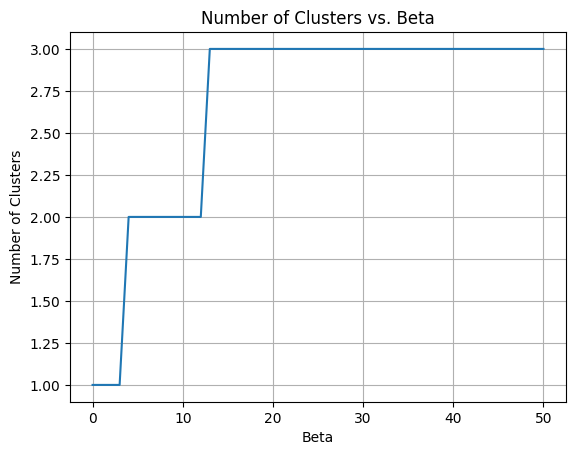

In [10]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [11]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=500, max_iter=5000, threshold=1e-5)

Iteration: 1 out of 5000
Objective function value: 0.9331667729447426
H(T) =  1.0985997641372804
I(T;Y) =  0.0003308659823850757
Iteration: 2 out of 5000
Objective function value: -31.502321078282325
H(T) =  0.9320068839288034
I(T;Y) =  0.06486865592442226
Iteration: 3 out of 5000
Objective function value: -42.532437741607
H(T) =  1.06697947307486
I(T;Y) =  0.08719883442936371
Iteration: 4 out of 5000
Objective function value: -44.586450501672076
H(T) =  1.0508886617447584
I(T;Y) =  0.09127467832683367
Iteration: 5 out of 5000
Objective function value: -45.58718024749152
H(T) =  1.032791537475946
I(T;Y) =  0.09323994356993492
Iteration: 6 out of 5000
Objective function value: -46.34740139792329
H(T) =  1.0113231523770283
I(T;Y) =  0.09471744910060065
Iteration: 7 out of 5000
Objective function value: -46.95637314103177
H(T) =  0.9904775157719385
I(T;Y) =  0.09589370131360742
Iteration: 8 out of 5000
Objective function value: -47.37477852199681
H(T) =  0.9750732436731604
I(T;Y) =  0.096

In [12]:
import re

# Define a function to extract the number from the column name
def extract_number(column_name):
    match = re.search(r'\d+', column_name)  # Search for one or more digits in the column name
    if match:
        return int(match.group())  # Return the first occurrence of digits as an integer
    else:
        return None  # Return None if no digits are found

In [13]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', data_used['cluster'].value_counts())

# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data_used.groupby(['cluster', 'Choice']).size().unstack(fill_value=0)
print('\n', cluster_counts)

data_used['max_proba'] = data_used[['P_1', 'P_2', 'P_3']].idxmax(axis=1).apply(extract_number)
cluster_counts2 = data_used.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = data_used.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 3

 cluster
1    2128
0     845
2     636
Name: count, dtype: int64

 Choice      1    2    3
cluster                
0         421  361   63
1        1797  165  166
2         286   63  287

 max_proba     1    2    3
cluster                  
0           641  204    0
1          2128    0    0
2           425    3  208

 simulated_choice     1    2    3
cluster                         
0                  452  335   58
1                 1725  205  198
2                  323   43  270


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3726/687862934.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['cluster'] = np.argmax(q_t_given_x, axis=1)
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_3726/687862934.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_used['max_proba'] = data_used[['P_1', 'P_2', 'P_3']].idxmax(axis=1).apply(extract_number)
